<a href="https://colab.research.google.com/github/mohamedbenzaied/classification_dialecte_tunisian/blob/main/ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score


# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:

df_train= pd.read_csv('/content/Train.csv')
print(df_train.shape)
df_train.head()


(70000, 3)


,ID,text,label
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1
3,U0TTYY8,ak slouma,1
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1


 1    38239
-1    29295
 0     2466
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


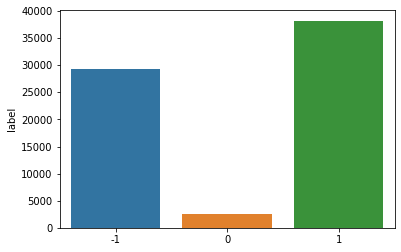

In [20]:
import seaborn as sns

x=df_train['label'].value_counts()
print(x)
sns.barplot(x.index,x)

In [21]:
df_train.isna().sum()


ID       0
text     0
label    0
dtype: int64

In [22]:
#1. WORD-COUNT
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['label']==1]['word_count'].mean()) #good 
print(df_train[df_train['label']==0]['word_count'].mean()) #neutre
print(df_train[df_train['label']==-1]['word_count'].mean()) #bad

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['label']==1]['char_count'].mean()) #good 
print(df_train[df_train['label']==0]['char_count'].mean()) #neutre
print(df_train[df_train['label']==-1]['char_count'].mean()) #bad

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['label']==1]['unique_word_count'].mean()) #good 
print(df_train[df_train['label']==0]['unique_word_count'].mean()) #neutre
print(df_train[df_train['label']==-1]['unique_word_count'].mean()) #bad




7.875389000758388
7.41970802919708
12.60204813108039
45.57404743847904
44.06812652068127
73.91353473288957
7.410889406103716
6.991889699918897
11.578460488137907


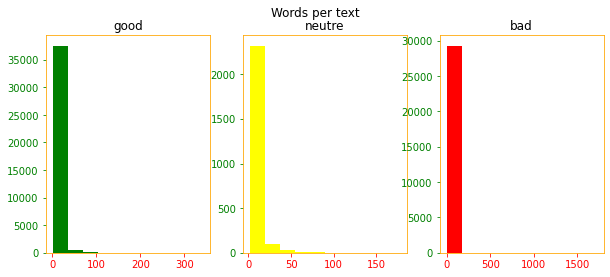

In [23]:
import numpy as np
import matplotlib.pyplot as plt 
with plt.rc_context({'axes.edgecolor':'orange', 'xtick.color':'red', 'ytick.color':'green', 'figure.facecolor':'white'}):
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))
    train_words=df_train[df_train['label']==1]['word_count']
    ax1.hist(train_words,color='green')
    ax1.set_title('good')
    train_words=df_train[df_train['label']==0]['word_count']
    ax2.hist(train_words,color='yellow')
    ax2.set_title('neutre')
    train_words=df_train[df_train['label']==-1]['word_count']
    ax3.hist(train_words,color='red')
    ax3.set_title('bad')
    fig.suptitle('Words per text')
    plt.show()

In [34]:
text = "   hedha msg bch yetnaaaaaadhef wina7y hajet zeyda: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text=re.compile( r"(.)\1+" ).sub( r"\1", text )
    return text
text=preprocess(text)
print(text)
 


hedha msg bch yetnadhef wina7y hajet zeyda adjacent spaces and tabs


In [35]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english') + stopwords.words('french')]
    return ' '.join(a)
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)
text = lemmatizer(text)
print(text)


hedha msg bch yetnadhef wina7y hajet zeyda adjacent space and tab


In [36]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,ID,text,label,clean_text
0,13P0QT0,3sbaaaaaaaaaaaaaaaaaaaa lek ou le seim riahi o...,-1,3sba lek seim riahi 3sba ca
1,SKCLXCJ,cha3eb fey9elkoum menghir ta7ayoul ou kressi,-1,cha3eb fey9elkoum menghir ta7ayoul kresi
2,V1TVXIJ,bereau degage nathef ya slim walahi ya7chiw fi...,-1,bereau degage nathef ya slim walahi ya7chiw fi...
3,U0TTYY8,ak slouma,1,ak slouma
4,68DX797,entom titmanou lina a7na 3iid moubarik a7na ch...,-1,entom titmanou lina a7na 3id moubarik a7na cha...


In [43]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


In [46]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [60]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 

              precision    recall  f1-score   support

          -1       0.76      0.80      0.78      5815
           0       0.59      0.17      0.26       477
           1       0.83      0.84      0.83      7708

    accuracy                           0.80     14000
   macro avg       0.73      0.60      0.63     14000
weighted avg       0.80      0.80      0.79     14000

Confusion Matrix: [[4674   26 1115]
 [ 217   79  181]
 [1228   30 6450]]


In [61]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

              precision    recall  f1-score   support

          -1       0.80      0.74      0.77      5815
           0       0.00      0.00      0.00       477
           1       0.79      0.88      0.84      7708

    accuracy                           0.80     14000
   macro avg       0.53      0.54      0.54     14000
weighted avg       0.77      0.80      0.78     14000

Confusion Matrix: [[4327    0 1488]
 [ 189    0  288]
 [ 893    0 6815]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))

              precision    recall  f1-score   support

          -1       0.66      0.80      0.72      5815
           0       0.00      0.00      0.00       477
           1       0.81      0.73      0.77      7708

    accuracy                           0.73     14000
   macro avg       0.49      0.51      0.50     14000
weighted avg       0.72      0.73      0.72     14000

Confusion Matrix: [[4631    0 1184]
 [ 339    0  138]
 [2092    1 5615]]


In [74]:
#Testing it on new dataset with the best model
df_test=pd.read_csv('/content/tst.csv')  #reading the data
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['label']= y_predict
print(df_test.head())
final=df_test[['ID','text','label']].reset_index(drop=True)
final.to_csv('submissionn.csv')

        ID                     text         clean_text  predict_prob  label
0  CS3H45A          produit ta7foun    produit ta7foun      0.023836      1
1  3DKDB2V         yaatikom saha <3     yatikom saha 3      0.011047      1
2  NHXTL3R       qualité taaml l3ar  qualité taml l3ar      0.009061     -1
3  U1YWB2O          fezdt fy chhar       fezdt fy char      0.031814     -1
4  O3KYLM0  khaaayeeeb baaarchaaaa       khayeb barcha      0.112403     -1
